## Load basic packages/modules

In [1]:
import os
import numpy as np
import pandas as pd

import nltk
from nltk import corpus, tokenize
from nltk.corpus import stopwords

import re

from nltk.stem import PorterStemmer, WordNetLemmatizer, porter
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

from sklearn.model_selection import train_test_split

# ML
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# DNN/MLP/ANN model

In [2]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


## Load the dataset

In [3]:
hotstar = pd.read_csv("hotstar_reviews.csv")
hotstar.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,08-10-2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,08-11-2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,08-12-2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,08-11-2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,08-05-2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [4]:
hotstar.shape

(5053, 13)

In [5]:
hotstar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5053 entries, 0 to 5052
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   5053 non-null   int64 
 1   UserName             4331 non-null   object
 2   Created_Date         5053 non-null   object
 3   Reviews              5053 non-null   object
 4   Lower_Case_Reviews   5053 non-null   object
 5   Sentiment_Manual_BP  5053 non-null   object
 6   Sentiment_Manual     5053 non-null   object
 7   Review_Length        5053 non-null   int64 
 8   DataSource           5053 non-null   object
 9   Year                 5053 non-null   int64 
 10  Month                5053 non-null   int64 
 11  Date                 5053 non-null   int64 
 12  Sentiment_Polarity   5053 non-null   object
dtypes: int64(5), object(8)
memory usage: 513.3+ KB


In [6]:
hotstar.Sentiment_Manual.value_counts()

Neutral     1738
Positive    1733
Negative    1582
Name: Sentiment_Manual, dtype: int64

In [7]:
hotstar.Sentiment_Manual.value_counts()/hotstar.Sentiment_Manual.size*100

Neutral     34.395409
Positive    34.296458
Negative    31.308134
Name: Sentiment_Manual, dtype: float64

In [8]:
# From above we can conclude that Sentiment_Manual is balanced

In [9]:
hotstar.DataSource.value_counts()/hotstar.DataSource.size*100

Twitter             55.927172
Google_PlayStore    44.072828
Name: DataSource, dtype: float64

In [10]:
pd.pivot_table(hotstar, index='Sentiment_Manual', columns='DataSource',
              values='ID', aggfunc='count')/hotstar.DataSource.size*100

DataSource,Google_PlayStore,Twitter
Sentiment_Manual,,
Negative,12.923016,18.385118
Neutral,5.125668,29.269741
Positive,26.024144,8.272313


In [11]:
hotstar.columns

Index(['ID', 'UserName', 'Created_Date', 'Reviews', 'Lower_Case_Reviews',
       'Sentiment_Manual_BP', 'Sentiment_Manual', 'Review_Length',
       'DataSource', 'Year', 'Month', 'Date', 'Sentiment_Polarity'],
      dtype='object')

## Data Cleaning

In [12]:
review_data = hotstar[['Lower_Case_Reviews','DataSource','Sentiment_Manual']]
review_data.head()

,Lower_Case_Reviews,DataSource,Sentiment_Manual
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [13]:
review_data.columns = ['Reviews','Source','Sentiment']
review_data.head()

,Reviews,Source,Sentiment
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [14]:
review_data.describe(include='object')

,Reviews,Source,Sentiment
count,5053,5053,5053
unique,5053,2,3
top,hh,Twitter,Neutral
freq,1,2826,1738


In [15]:
review_data.Source.value_counts()

Twitter             2826
Google_PlayStore    2227
Name: Source, dtype: int64

In [16]:
review_data['Source'] = review_data['Source'].astype('category')
review_data['Source'] = review_data['Source'].cat.codes
review_data['Source'].value_counts()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31984\3689932828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Source'] = review_data['Source'].astype('category')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31984\3689932828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Source'] = review_data['Source'].cat.codes


1    2826
0    2227
Name: Source, dtype: int64

In [17]:
review_data.head()

,Reviews,Source,Sentiment
0,hh,0,Negative
1,no,0,Negative
2,@hotstar_helps during paymnt for premium subsc...,1,Negative
3,@hotstartweets i am currently on jio network a...,1,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative


In [18]:
review_data.Sentiment.value_counts()

Neutral     1738
Positive    1733
Negative    1582
Name: Sentiment, dtype: int64

In [19]:
review_data['Sentiment'] = review_data['Sentiment'].astype('category')
review_data['Sentiment'] = review_data['Sentiment'].cat.codes
review_data['Sentiment'].value_counts()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31984\766554302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Sentiment'] = review_data['Sentiment'].astype('category')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31984\766554302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Sentiment'] = review_data['Sentiment'].cat.codes


1    1738
2    1733
0    1582
Name: Sentiment, dtype: int64

In [20]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
punctuation = list(string.punctuation)

stop_words = stopwords.words('english')

re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\d]+[a-zA-Z_+='?]+[\d]+[\d]+|[a-zA-Z_*+=]+[\d]+[a-zA-Z_*+-=]+|[\d]+"""

re_patter = re_pattern + """|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt"""

reviewText = [re.sub(pattern = re_pattern, string = text, repl="") 
               for text in review_data.Reviews.map(str).values]

In [22]:
re_pattern

'@[a-zA-Z0-9_:]+|b[\'"]rt|[\\d]+[a-zA-Z_+=\'?]+[\\d]+[\\d]+|[a-zA-Z_*+=]+[\\d]+[a-zA-Z_*+-=]+|[\\d]+'

In [23]:
print(reviewText[3])

 i am currently on jio network and would like to know whether i will be able to watch epl telecasted on star sports select hd


In [24]:
review_data_cleaned = []

for review in reviewText:
    stop_free = " ".join([txt for txt in review.lower().split() if txt not in stop_words])
    # stop_words - NLTK
    stop_free_1 = " ".join([txt for txt in stop_free.lower().split() if txt not in STOPWORDS])
    # STOPWORDS - WORDCLOUD
    puct_free = " ".join([txt for txt in stop_free_1.lower().split() if txt not in punctuation])
    review_data_cleaned.append(puct_free)

In [25]:
# remove hashtags
review_data_cleaned_final = []

for rdcf in review_data_cleaned:
    final_words = rdcf.replace("#",'')
    review_data_cleaned_final.append(final_words)


In [26]:
review_data_cleaned_final[7]

'today epi lovekahaiintezaar nt available available morning showing nt available due expiry'

## Lemmatization

In [27]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
wd = WordNetLemmatizer()

review_data_cleaned_final_output = []
for rdc in review_data_cleaned_final:
    clean_review = " ".join(wd.lemmatize(word) for word in rdc.split())
    review_data_cleaned_final_output.append(clean_review)

In [29]:
review_data_cleaned_final_output

['hh',
 '',
 'paymnt premium subscription transaction failed twice received refund one transaction',
 'currently jio network know whether able watch epl telecasted star sport select hd',
 'episode sarabhai v sarabhai season downloadable able watch offline please smthng',
 'able watch latest episode got app allow take screenshot error help resolve asap',
 'please allow rupay maestro payment gateway premium membership mean paytm work thru debit card great',
 'today epi lovekahaiintezaar nt available available morning showing nt available due expiry',
 'hotstarfraud paid subscription july havent received cashback specified hdfc card',
 'premium accnt hotstar showing tht premium member u pls chk',
 'seeing blank page term amp condition hdfc bank cashback offer hotstar premium membership please help',
 'sir please allow u download video ur app present option allow u dwnld mre video due ltd space',
 'hi pl tab sport homepage isl bundesliga search team name stream pls look',
 'unable watch st

In [30]:
review_data['clean_review'] = review_data_cleaned_final_output

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_31984\3331724023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['clean_review'] = review_data_cleaned_final_output


In [31]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,0,hh
1,no,0,0,
2,@hotstar_helps during paymnt for premium subsc...,1,0,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,0,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,0,episode sarabhai v sarabhai season downloadabl...


## Split the data into training and test

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(review_data['clean_review'],
                                                review_data['Sentiment'],test_size=0.2,
                                                   random_state=42,
                                                   stratify=review_data['Sentiment'])

In [33]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4042,) (1011,) (4042,) (1011,)


## Feature Extraction

In [34]:
# vectorize the text data using CountVectorizer

vectorizer = CountVectorizer(binary=True).fit(x_train)
x_train_vectorized = vectorizer.transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [35]:
x_train

2669                                             good aap
4312    suddenly start buffering n buffering n bufferi...
2512    watch bengaluru bull v telugu titan live star ...
2722                                             osam app
3254                                             easy use
                              ...                        
350                                           app working
4952    glad waited watched latest gameofthrones episo...
958     called live feed exact second delayed transmis...
67      order id premium membership cancelled free tra...
749     use image promotional tweet understand spoiler...
Name: clean_review, Length: 4042, dtype: object

In [36]:
x_train_vectorized

<4042x4978 sparse matrix of type '<class 'numpy.int64'>'
	with 25167 stored elements in Compressed Sparse Row format>

In [41]:
print(vectorizer.get_feature_names_out())

['aa' 'aaaaaand' 'aaaaah' ... 'zinab' 'zindabad' 'znmd']


In [42]:
pd.DataFrame(x_train_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
pd.DataFrame(x_test_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Building

In [44]:
from sklearn.naive_bayes import MultinomialNB

In [45]:
naive_bayes_multi = MultinomialNB().fit(x_train_vectorized, y_train)

In [46]:
print(naive_bayes_multi.score(x_train_vectorized, y_train))
print()
print(naive_bayes_multi.score(x_test_vectorized, y_test))

0.8805047006432459

0.7190900098911969


In [49]:
predict_train = naive_bayes_multi.predict(x_train_vectorized)
predict_test = naive_bayes_multi.predict(x_test_vectorized)

In [50]:
print(classification_report(y_train,predict_train ))
print()
print(classification_report(y_test,predict_test ))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1266
           1       0.91      0.82      0.86      1390
           2       0.90      0.91      0.91      1386

    accuracy                           0.88      4042
   macro avg       0.88      0.88      0.88      4042
weighted avg       0.88      0.88      0.88      4042


              precision    recall  f1-score   support

           0       0.68      0.76      0.72       316
           1       0.68      0.67      0.68       348
           2       0.81      0.73      0.77       347

    accuracy                           0.72      1011
   macro avg       0.72      0.72      0.72      1011
weighted avg       0.72      0.72      0.72      1011



In [52]:
print(accuracy_score(y_train,predict_train ))
print()
print(accuracy_score(y_test,predict_test ))

0.8805047006432459

0.7190900098911969


## Random Forest Classifier

In [53]:
rf_model = RandomForestClassifier().fit(x_train_vectorized, y_train)

In [54]:
print(rf_model.score(x_train_vectorized, y_train))
print()
print(rf_model.score(x_test_vectorized, y_test))

0.9935675408213755

0.7101879327398615


In [55]:
predict_train1 = rf_model.predict(x_train_vectorized)
predict_test1 = rf_model.predict(x_test_vectorized)

In [57]:
print(classification_report(y_train,predict_train))
print()
print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1266
           1       0.91      0.82      0.86      1390
           2       0.90      0.91      0.91      1386

    accuracy                           0.88      4042
   macro avg       0.88      0.88      0.88      4042
weighted avg       0.88      0.88      0.88      4042


              precision    recall  f1-score   support

           0       0.68      0.76      0.72       316
           1       0.68      0.67      0.68       348
           2       0.81      0.73      0.77       347

    accuracy                           0.72      1011
   macro avg       0.72      0.72      0.72      1011
weighted avg       0.72      0.72      0.72      1011



In [59]:
print(accuracy_score(y_train,predict_train1 ))
print()
print(accuracy_score(y_test,predict_test1 ))

0.9935675408213755

0.7101879327398615


## K Fold method

In [58]:
from sklearn.model_selection import cross_val_score
training_accuracy = cross_val_score(rf_model, x_train_vectorized, y_train, cv=10)
print(training_accuracy.mean())

0.7389817870675957


## XGBoost Classifier

In [60]:
xgboost = XGBClassifier().fit(x_train_vectorized, y_train)

In [62]:
print(xgboost.score(x_train_vectorized, y_train))
print()
print(xgboost.score(x_test_vectorized, y_test))

0.8310242454230579

0.7062314540059347


In [63]:
from sklearn.model_selection import cross_val_score
training_accuracy = cross_val_score(xgboost, x_train_vectorized, y_train, cv=10)
print(training_accuracy.mean())

0.736268182373793


## Feature Extraction - Term Frequency - Inverse Documents Frequency (TF-IDF)

In [64]:
# vectorize the text data using TfidfVectorizer
tf_idf = TfidfVectorizer().fit(x_train)
x_train_tf_idf = tf_idf.transform(x_train)
x_test_tf_idf = tf_idf.transform(x_test)

In [65]:
pd.DataFrame(x_test_tf_idf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
x_test_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
xgboost = XGBClassifier().fit(x_train_tf_idf, y_train)

In [68]:
print(xgboost.score(x_train_tf_idf, y_train))
print()
print(xgboost.score(x_test_tf_idf, y_test))

0.8871845620979713

0.7091988130563798


## Analysis using WordCloud

In [69]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,0,hh
1,no,0,0,
2,@hotstar_helps during paymnt for premium subsc...,1,0,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,0,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,0,episode sarabhai v sarabhai season downloadabl...


In [70]:
review_data.Sentiment.value_counts()

1    1738
2    1733
0    1582
Name: Sentiment, dtype: int64

In [77]:
positive_review = review_data[review_data['Sentiment']==2]['clean_review']
negative_review = review_data[review_data['Sentiment']==0]['clean_review']
neutral_review = review_data[review_data['Sentiment']==1]['clean_review']

In [78]:
positive_review.shape, negative_review.shape, neutral_review.shape

((1733,), (1582,), (1738,))

In [80]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [81]:
pos_data_token = [nltk.word_tokenize(rvw) for rvw in positive_review]
neg_data_token = [nltk.word_tokenize(rvw) for rvw in negative_review]
neu_data_token = [nltk.word_tokenize(rvw) for rvw in neutral_review]

In [82]:
neu_data_token

[[],
 ['speed'],
 ['sss'],
 ['sunni'],
 ['app'],
 ['thank'],
 ['ufgjj'],
 ['vipul'],
 ['fghk'],
 ['god'],
 ['att', 'aa'],
 ['better'],
 ['crazzy'],
 ['hank'],
 ['ok'],
 ['kiduve'],
 ['krunal'],
 ['raju'],
 ['mash'],
 ['mmmmmm'],
 ['ok'],
 ['peasad'],
 ['rakesh'],
 ['rayudu'],
 ['salmon'],
 ['serial'],
 ['shahal'],
 ['thanks'],
 [],
 ['average'],
 ['clearty'],
 ['cricket'],
 ['forever'],
 ['hotstar'],
 ['ok'],
 ['ok'],
 ['kp', 'joel'],
 ['live', 'tv'],
 ['love'],
 ['machand'],
 ['must'],
 ['nit', 'bad'],
 ['word'],
 ['bad'],
 ['yet'],
 ['nothing'],
 ['ooooooo'],
 ['praveen'],
 ['quality'],
 ['sahi', 'hi'],
 ['sandeep'],
 ['sirraaa'],
 ['sonysab'],
 ['subhash'],
 ['tv', 'show'],
 ['vismaya'],
 ['well'],
 [],
 ['chuyyapa'],
 ['download'],
 ['hawa', 'xaw'],
 ['itds', 'okk'],
 ['word'],
 ['nrrrrrrr'],
 ['pudikale'],
 ['raj', 'bhai'],
 ['semmaiya'],
 ['shailesh'],
 ['thankyou'],
 ['abhi', 'abhi'],
 ['buffering'],
 ['chhota', 'tv'],
 ['hostar'],
 ['hq', 'video'],
 ['okay'],
 ['likhith'],
 ['k

In [83]:
wordcloud_pos = WordCloud(background_color='blue', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(pos_data_token))

wordcloud_neg = WordCloud(background_color='white', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(neg_data_token))

wordcloud_neu = WordCloud(background_color='black', max_words=200, max_font_size=40,
                         scale=3, random_state=10).generate(str(neu_data_token))

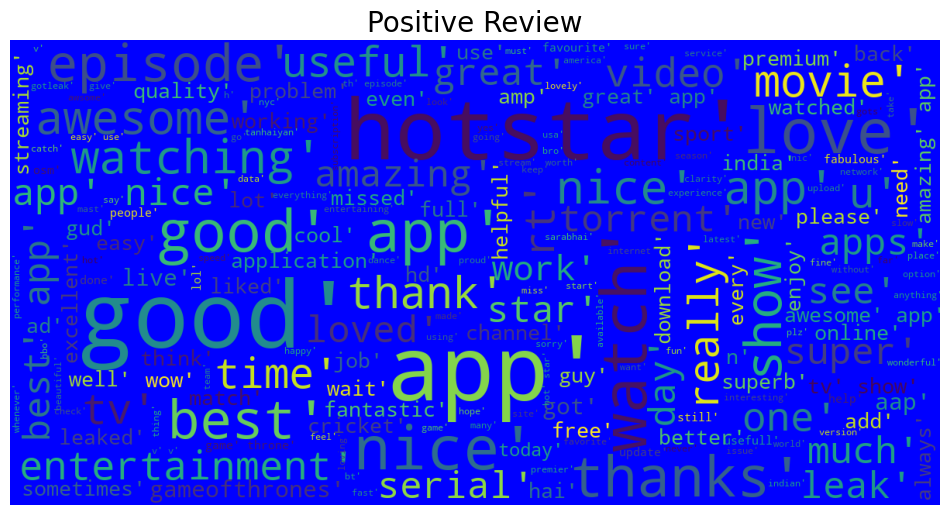

In [84]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_pos)
plt.title("Positive Review", size=20)
plt.show()

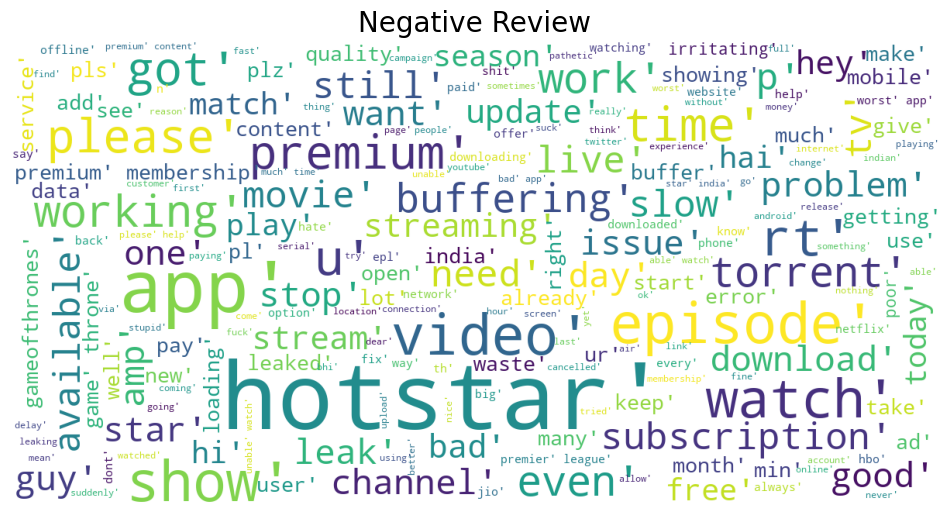

In [85]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neg)
plt.title("Negative Review", size=20)
plt.show()

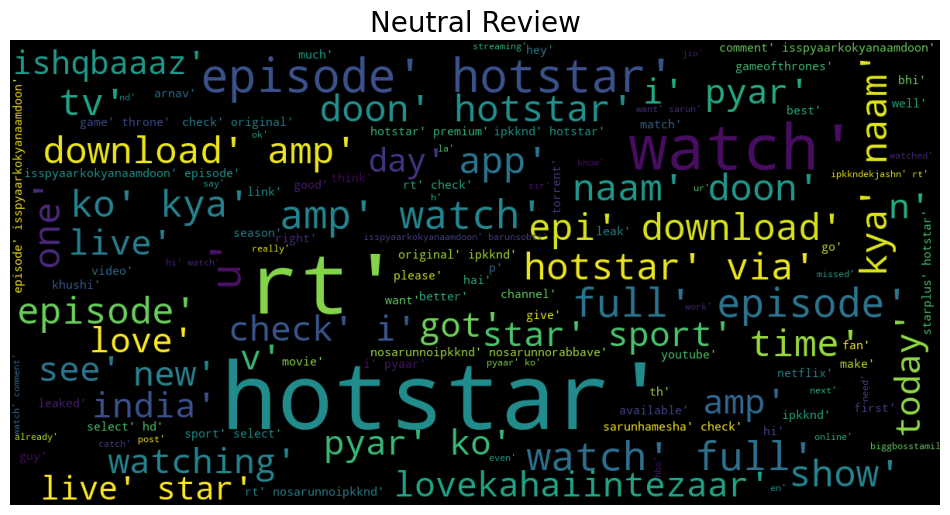

In [86]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neu)
plt.title("Neutral Review", size=20)
plt.show()